**Importy**

In [2]:
import regex
import json, ast
from csv import writer
import pandas as pd 
import numpy as np
from stop_words import get_stop_words
import seaborn as sns
import pickle


In [5]:
import majka
from majka import Majka
morph = Majka('../data/w-lt.sk.fsa')

morph.flags |= majka.ADD_DIACRITICS  # find word forms with diacritics
morph.flags |= majka.DISALLOW_LOWERCASE  # do not enable to find lowercase variants
morph.flags |= majka.IGNORE_CASE  # ignore the word case whatsoever
morph.flags = 0  # unset all flags

morph.tags = False  # return just the lemma, do not process the tags
# morph.tags = True  # turn tag processing back on (default)

morph.first_only = True  # return only the first entry
# morph.first_only = False  # return all entries (default)

In [6]:
from corpy.morphodita import Tagger
tagger = Tagger("../data/slovak-morfflex-pdt-170914.tagger")

INFO:corpy.morphodita:Loading tagger.


In [7]:
import nltk
nltk.download('punkt')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rusna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
DEBUG = False

**Premenne**

In [9]:
# file s jednou page
debug_filepath = "../data/test_data_1page.xml"
# cely file
input_filepath = "../data/skwiki-latest-pages-articles.xml"
output_filepath = "../data/anchors.csv"
THRESHOLD = 2

**Funkcie**

In [10]:
# otvorenie suboru, zadefinovanie hlavicky csv suboru a nasledne citanie s pracovanie po riadkoch
def open_read(input_filepath,output_filepath,process):
    with open(input_filepath, encoding='UTF-8') as input_file ,open(output_filepath, 'w+', encoding='UTF-8' ) as output_file:
        csv_writer = writer(output_file, delimiter='|')
        csv_writer.writerow(["Link", "Alt_Text"])
        for line in input_file:
            process(line,csv_writer)

In [11]:
# využitie regexu na nájdene všetkých zhôd v riadku a zapísanie do csv súboru. 
def process(line,csv_writer):
    regex_patern = '\[\[([^|\]\]]+)\|?([^|\]\]]+)?\]\]'
    
    matches = regex.findall(regex_patern, line) 
    for match in matches:
        list_matche = list(filter(None, match))
        
        
        csv_writer.writerow(list_matche)

In [12]:
# funkcia pre upravu textu
def replace(text, regex_pattern, substitution):
    if not isinstance(text, str):
        return text
    return regex.sub(regex_pattern,substitution,text)

In [13]:
# funkcia pre tokenizovanie textu. Text -> Vety -> Slova (Tokeny) vyuzitim nltk 
def tokenizer_modded(text):
#     print('text:', text)
    if not pd.isna(text):
#         print(type(text))
        
        if isinstance(text, int) or isinstance(text, float):
            text = str(text)
            
    
        sentences = nltk.sent_tokenize(text)
#         print('sentence:',sentences)
        tokens = []
        for sent in sentences:
            tokens.append(nltk.word_tokenize(sent))
        flatten_list = [j for sub in tokens for j in sub] 
#         print('list',flatten_list)

        result = [token.lower() for token in flatten_list if token not in ".,?!...-nan"]

        return result
    else:
        return []

In [14]:
# lematizovanie textu s odstranenim stop slov. Vyuziva sa majka so Slovenskym Slovnikom
def lematizer_modded(text):
    stop_words = get_stop_words('sk')

    result = []
    for word in ast.literal_eval(text):
        morph_word = morph.find(word)
#         Aktualne slova ktore nemaju lemu, budu mat povodny tvar.
        if morph_word:
            result.append(morph_word[0]['lemma'])
        else:
            if hashmap_unlem[word] > THRESHOLD:
                result.append(word)
            
    for word in result:  # odstranenie stopslov
        if word in stop_words:
            result.remove(word)
    return result

In [15]:
def fill_hashmap(text):
  
    for word in text:
        morph_word = morph.find(word)
        if morph_word == []:
            
            if not word in hashmap_unlem:
                hashmap_unlem[word] = 1
            else:
#                 if hashmap_unlem[word] <= THRESHOLD:
                hashmap_unlem[word] += 1 


#### Aplikovanie funkcii

In [16]:
def process_data(df):
    for column in df:
        df[column] = df[column] \
        .apply(lambda x: x if x is not np.NaN else None) \
        .apply(replace,regex_pattern = r"[\\\/\(\):#.\_?!]|({{.*}})|\d*px\d*png\d*svg\d*jpg",substitution =' ')\
        .apply(replace,regex_pattern = r"([ ]+)",substitution =' ')\
        
    return df

In [17]:
def tokenize_data(df):
    for column in df:
        df[column] = df[column] \
        .apply(lambda text: tokenizer_modded(text) if text is not None else [] )
        
    return df

In [18]:
def lemetize_data(df):
    for column in df:
        df[column] = df[column] \
        .apply(lambda text: lematizer_modded(text) )
        
    return df

In [19]:
def create_hashmap(df):
    for column in df:
        df[column] \
        .apply(lambda text: fill_hashmap(text) )


**Priebeh spracovania**

In [17]:
if DEBUG:
    open_read(debug_filepath,output_filepath,process)
else:
    open_read(input_filepath,output_filepath,process)


In [21]:
# spracovanie suboru po chunkoch a postupne ukladanie vysledkov do csv
hashmap_unlem = {}  
for index,chunk in enumerate(pd.read_csv(output_filepath, chunksize=500, delimiter='|')):
    

    process_data(chunk)
    chunk = tokenize_data(chunk)
    create_hashmap(chunk)
    chunk.to_csv('../data/tokenized_data.csv', mode = 'a+', index=False, header=False, encoding='UTF-8')

In [19]:
for index,chunk in enumerate(pd.read_csv('../data/tokenized_data.csv',chunksize=500, names=["Link","Alt_Text"])):
    

    lemetize_data(chunk)
    chunk.to_csv('../data/done.csv', mode = 'a+', index=False,header=False, encoding='UTF-8')


In [20]:
with open('../data/hashmap.json', 'w') as fp:
    json.dump(hashmap_unlem, fp)

## Analyza dat

In [1]:
data = pd.read_csv('../data/done.csv', names=["Link","Alt_Text"])

NameError: name 'pd' is not defined

In [5]:
# Počet a typ výskytu slov v anchor textoch a linkoch
pocet_alt = 0
pocet_link = 0
pocet_lem_alt = 0
pocet_lem_link = 0
pocet_unlem_alt = 0
pocet_unlem_link = 0
for index,chunk in enumerate(pd.read_csv('../data/done.csv',chunksize=500, names=["Link","Alt_Text"])):
    for column in chunk:
        for i in chunk[column]:
            for x in (ast.literal_eval(i)):
                if column == 'Link':
                    pocet_link +=1
                else:
                    pocet_alt +=1
                if not x in hashmap_unlem:
                    if column == 'Link':
                        pocet_lem_link +=1
                    else:
                        pocet_lem_alt +=1
                if x in hashmap_unlem:
                    if column == 'Link':
                        pocet_unlem_link +=1
                    else:
                        pocet_unlem_alt +=1
                        
print(f"Stlpec: Link, Pocet slov: {pocet_link}")
print(f"Stlpec: Alt_text, Pocet slov: {pocet_alt}")
print(f"----------------------------------------------------------")
print(f"Stlpec: Link, Pocet lematizovanych slov: {pocet_lem_link}")
print(f"Stlpec: Alt_text, Pocet lematizovanych slov: {pocet_lem_alt}")
print(f"----------------------------------------------------------")
print(f"Stlpec: Link, Pocet nelematizovanych slov: {pocet_unlem_link}")
print(f"Stlpec: Alt_text, Pocet nelematizovanych slov: {pocet_unlem_alt}")


Stlpec: Link, Pocet slov: 16561266
Stlpec: Alt_text, Pocet slov: 4355024
----------------------------------------------------------
Stlpec: Link, Pocet lematizovanych slov: 7915955
Stlpec: Alt_text, Pocet lematizovanych slov: 1904610
----------------------------------------------------------
Stlpec: Link, Pocet nelematizovanych slov: 8645311
Stlpec: Alt_text, Pocet nelematizovanych slov: 2450414


In [3]:
with open('../data/hashmap.json') as json_file:
    hashmap_unlem = json.load(json_file)

In [24]:
# pocet uniq slov ktore neprekrocili threshold
counter_removed = 0
counter_saved = 0
counter_total = 0
for i in hashmap_unlem.values():
    counter_total += i 
    if i < 2:
        counter_removed +=1
    if i >= 2:
        counter_saved +=1
print(f"Pocet uniq slov, ktorych vyskyt je mensi nez threshold: {counter_removed}")      
print(f"Pocet uniq slov, ktorych vyskyt je vacsi nez threshold: {counter_saved}")        
print(f"Sucet slov, ktore nemaju lemu: {counter_total}")           

Pocet uniq slov, ktorych vyskyt je mensi nez threshold: 344686
Pocet uniq slov, ktorych vyskyt je vacsi nez threshold: 333298
Sucet slov, ktore nemaju lemu: 11669093


In [4]:
df_histogram = pd.DataFrame({'word':list(hashmap_unlem.keys()),'count':list(hashmap_unlem.values())})

C:\Users\rusna\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


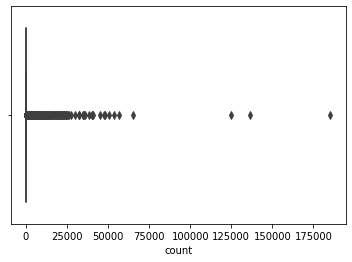

In [5]:
# boxplot zobrazujúci vychýlené hodnoty
sns.boxplot(df_histogram['count'])

In [4]:
# výpis vychýlených hodnôt
df_histogram[df_histogram['count'] > df_histogram['count'].quantile(.95)]

NameError: name 'df_histogram' is not defined

In [2]:
# odstránenie vychýlených hodnôt
y = df_histogram['count']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))
df_histogram.drop(df_histogram[~removed_outliers].index, inplace=True)

NameError: name 'df_histogram' is not defined

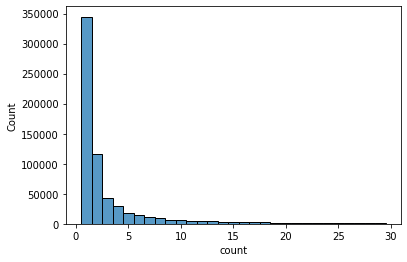

In [10]:
sns.histplot(df_histogram['count'],discrete=True)

C:\Users\rusna\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


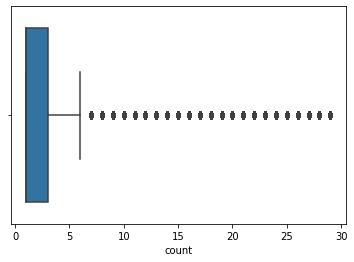

In [11]:
# Výpis 
sns.boxplot(df_histogram['count'])